In [ ]:
%load_ext autoreload
%autoreload 2

import dotenv
import IPython

import numpy as np

from backend import gmaps
from backend.location import Location, spherical_distance

dotenv.load_dotenv()

In [ ]:
# center = Location(lat=51.510760, lng=-0.098481)
center = Location(lat=51.51085332781443, lng=-0.1007581488010626)
size_pixels = 640
zoom = 15

In [ ]:
from backend.grid import get_map_dimensions


map_size_lat, map_size_lng = get_map_dimensions(center, zoom, size_pixels)

radius = 0.25

circle_locations = []
for i in range(0, 360, 10):
    radians = np.deg2rad(i)
    circle_locations.append(
        center.with_offset(
            lat=np.cos(radians) * map_size_lat * radius,
            lng=np.sin(radians) * map_size_lng * radius,
        )
    )

In [ ]:
image = gmaps.get_static_map(
    center,
    zoom=zoom,
    markers=[center] + circle_locations,
    size_pixels=size_pixels,
)
IPython.display.Image(image)

In [ ]:
from backend.gmaps import get_api_key
import requests

def call_compute_routes_api(origin: Location, destination: Location) -> dict:
    payload = {
        "origin": origin.to_route_matrix_location()["waypoint"],
        "destination": destination.to_route_matrix_location()["waypoint"],
        # "origin": center.to_route_matrix_location()["waypoint"],
        # "destination": circle_locations[1].to_route_matrix_location()["waypoint"],
        "travelMode": "WALK",
        "languageCode": "en-US",
        "polylineEncoding": "GEO_JSON_LINESTRING",
    }

    response = requests.post(
        "https://routes.googleapis.com/directions/v2:computeRoutes",
        json=payload,
        headers={
            "X-Goog-Api-Key": get_api_key(),
            "X-Goog-FieldMask": ",".join(
                [
                    "routes.duration",
                    "routes.distanceMeters",
                    "routes.polyline.geoJsonLinestring",
                    # "routes.polyline.geoJsonLinestring",

                ]
            ),
        },
    )
    response.raise_for_status()

    return response.json()

In [ ]:
responses = [call_compute_routes_api(center, c) for c in circle_locations]

In [ ]:
durations = [int(r["routes"][0]["duration"][:-1]) for r in responses]
durations

In [ ]:
from backend.location import Polyline

polylines = [
    Polyline.from_route_response(response["routes"][0]) for response in responses
]

In [ ]:
shortened_points = [
    p.get_point_at_fraction(min(1, 600 / d)) for p, d in zip(polylines, durations)
]

In [ ]:
image = gmaps.get_static_map(
    center,
    zoom=zoom,
    markers=[center] + shortened_points,
    size_pixels=size_pixels,
)
IPython.display.Image(image)

In [47]:
naive_shortened_points = [
    # we clamp from below to smooth out outliers - mainly points in the Thames
    # where it's not clear what the output should even be
    center.interpolate(c, max(np.median(durations) / d, 0.8))
    for c, d in zip(circle_locations, durations)
]

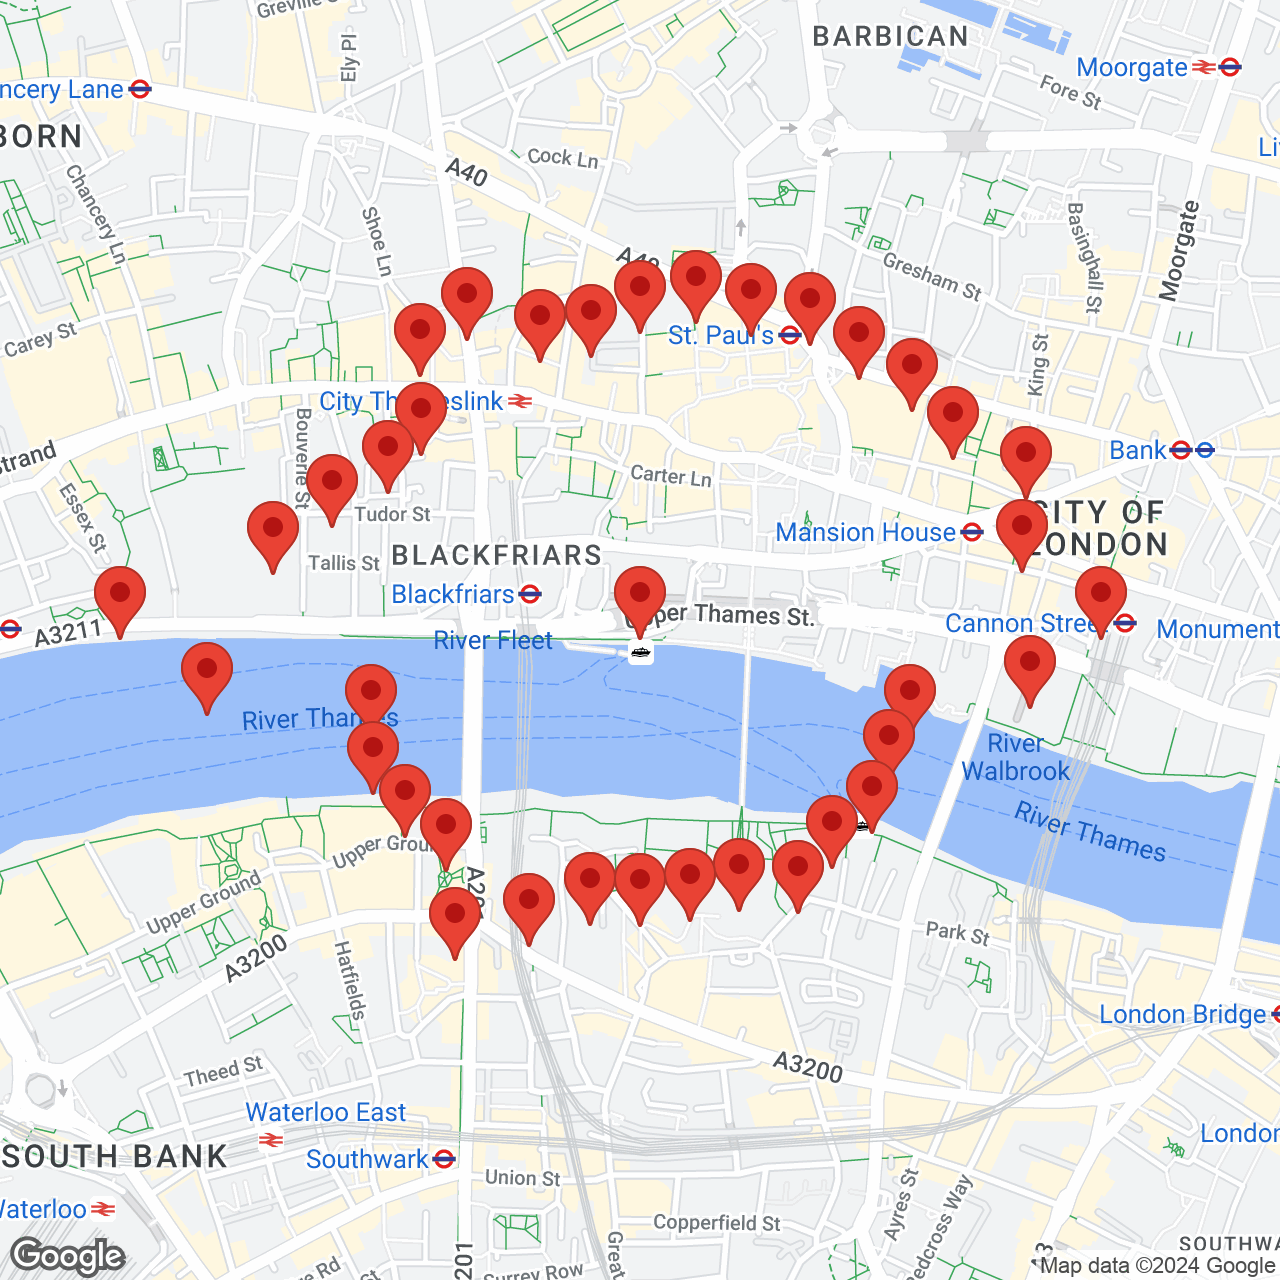

In [48]:
image = gmaps.get_static_map(
    center,
    zoom=zoom,
    markers=[center] + naive_shortened_points,
    # markers=[center],
    size_pixels=size_pixels,
)
IPython.display.Image(image)

In [45]:
import pandas as pd

In [46]:
df = pd.DataFrame(
    {
        "space_lat": [p.lat for p in circle_locations],
        "space_lng": [p.lng for p in circle_locations],
        "time_lat": [p.lat for p in naive_shortened_points],
        "time_lng": [p.lng for p in naive_shortened_points],
    }
)
df.to_csv("../actual-video/spacetime_circle_2.csv", index=False)

In [ ]:
shortened_points

In [ ]:
naive_shortened_points